## Preliminaries

#### Imports

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Allows auto reloading of modules
%load_ext autoreload
%autoreload 2

In [3]:
# Add path to src folder to the path variable 
PATH_TO_SRC = "./src"

if PATH_TO_SRC not in sys.path:
  sys.path.append(PATH_TO_SRC)

In [4]:
from data_preprocessor import DataPreprocessor
from data_clusterer import DataClusterer

#### Parameters

In [5]:
from config import MOVIES_PATH, GENRES_PATH, TEST_SIZE, RANDOM_STATE, MAX_DF, MIN_DF, STOP_WORDS, N_COMPONENTS, NORMALIZER_COPY, N_CLUSTERS, MAX_ITER, N_INIT

#### Instantiated classes

In [6]:
kmeans = KMeans(n_clusters=N_CLUSTERS, max_iter=MAX_ITER, n_init=N_INIT)

## Preprocessing

In [7]:
preprocessor = DataPreprocessor(MOVIES_PATH, GENRES_PATH)
preprocessor.df_movies.head()

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.91
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.57
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.32
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,Interstellar,2014.0,Mankind was born on Earth. It was never meant ...,The adventures of a group of explorers who mak...,169.0,4.32


In [8]:
preprocessor.df_genres.head()

,id,genre
0,1000001,Comedy
1,1000001,Fantasy
2,1000001,Adventure
3,1000002,Comedy
4,1000002,Thriller


#### Data Cleaning and Splitting

In [9]:
preprocessor.handleDataFrame()
X_train, X_test, y_train, y_test = preprocessor.splitData(TEST_SIZE, RANDOM_STATE)
X_train_desc_only = X_train.description

Reduced Length:  540740
Reduced Columns:  Index(['id', 'genre', 'name', 'description', 'rating'], dtype='object')


In [10]:
X_train_desc_only

585217    In this intimate and surprising documentary, t...
122446    The Stooges, not faring well with their diner,...
229370    The plot revolves around the life of three you...
197995    A young soldier's fear during an artillery att...
398017    Mumbai-based Rajendra Gupta works for Global I...
                                ...                        
110799    In a modern-day adaptation of Charles Dickens'...
266435    A passionate woman, a perfect idea and a vulne...
389542    An anti-hunting short film film made for the H...
132826    The life and career of Clarence Darrow, the no...
122680    Zero finds himself trapped within a universal ...
Name: description, Length: 378518, dtype: object

#### Vectorization

In [11]:
X_tfidf, features = preprocessor.vectorizeData(X_train_desc_only, MAX_DF, MIN_DF, STOP_WORDS)

Vectorized in 11.842 s
# of Samples: 378518
# of Features: 81591
% of Nonzero Entries: 0.010


In [12]:
X_tfidf[0]

<1x81591 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

#### Dimensionality Reduction

In [13]:
genres = preprocessor.countGenres()
X_lsa, lsa = preprocessor.reduceDim(X_tfidf, N_COMPONENTS, NORMALIZER_COPY)

# of Genres:  19
Unique Genres:
                     id
genre                  
Action            19194
Adventure          8827
Animation         39939
Comedy            89726
Crime             15459
Documentary      138760
Drama            153192
Family            12476
Fantasy            9163
History            7233
Horror            31020
Music             29414
Mystery            8362
Romance           23825
Science Fiction    9519
TV Movie          10236
Thriller          21435
War                4647
Western            6205
LSA done in 37.147 s
Explained variance of the SVD step: 5.1%


In [14]:
X_lsa.shape

(378518, 50)

## Clustering and Optmizing K

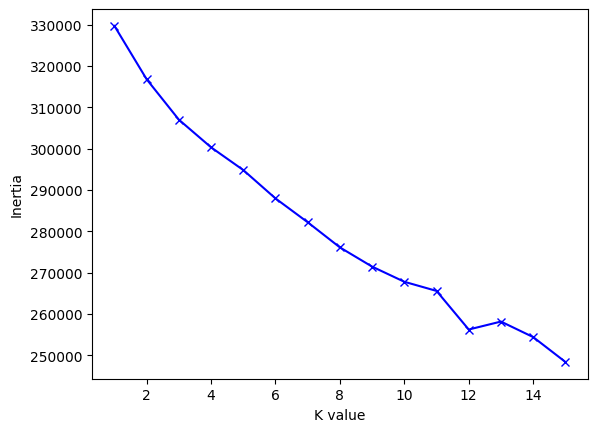

In [15]:
clusterer = DataClusterer(X_lsa, N_CLUSTERS, MAX_ITER, N_INIT)
K, inertias = clusterer.computeKMeansInertia()

In [16]:
optimal_k = 15
centers, y_kmeans, inertia = clusterer.computeKMeans(optimal_k)
clusterer.getClusters(optimal_k, centers, features, lsa)

Cluster 0: story tells based true film life love people young years family set journey man time way war told children history 
Cluster 1: friends best group make party trip night years family life goes decide new meet school help come childhood gets lives 
Cluster 2: documentary film short making life history interviews people work world footage american years director feature music follows filmmaker scenes explores 
Cluster 3: man young wife life finds old gets tries mysterious family goes past father takes home meets time death daughter way 
Cluster 4: police gets murder gang help crime money goes detective killer tries work brother case way takes officer make job drug 
Cluster 5: journey finds takes past mysterious work american people way place history children years little human set earth future animated group 
Cluster 6: woman young husband man life mysterious finds love meets married takes past beautiful gets relationship story goes falls men night 
Cluster 7: world war ii new j

In [20]:
X_train_clustered = X_train.assign(cluster=y_kmeans)
X_train_clustered.loc[X_train_clustered['cluster'] == 11].sort_values('rating', ascending=False).head(10)

,id,genre,name,description,rating,cluster
3330,1003332,Romance,Nathan for You: Finding Frances,Nathan attempts to help a Bill Gates impersona...,4.47,11
624,1000625,Drama,Cinema Paradiso,"A filmmaker recalls his childhood, when he fel...",4.44,11
1319,1001320,Drama,The Red Shoes,"In this classic drama, Vicky Page is an aspiri...",4.38,11
1387,1001388,Drama,Wild Strawberries,Crotchety retired doctor Isak Borg travels fro...,4.33,11
4551,1004553,Documentary,For Sama,A love letter from a young mother to her daugh...,4.33,11
1756,1001758,Romance,The Young Girls of Rochefort,Delphine and Solange are two sisters living in...,4.30,11
353,1000354,Comedy,Chungking Express,Two melancholic Hong Kong policemen fall in lo...,4.30,11
17496,1017532,Comedy,Daniel Sloss: X,"Daniel Sloss discusses a variety of topics, fr...",4.27,11
859,1000860,Drama,Metropolis,In a futuristic city sharply divided between t...,4.26,11
26735,1026804,Music,BEYONCÉ,"Developed as a ""visual album"", Beyoncé's songs...",4.26,11


In [ ]:
np.save('cluster_centers.npy', centers)
X_train_clustered.to_csv('clustered_movies.csv')

In [ ]:
# TODO
# Export clustered data
# Given block of text, convert it into 100-dim vector
# Compute euclidean distance for each centroid
# Return cluster with minimum distance
# Given the returned cluster, shoot out all other movies in the same cluster

In [27]:
from input_processor import processInput
text = "Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored. With no evidence to convict him, he is released and goes on to attain the position of hospital director. Nine years later when Dr. Tenma saves the life of a criminal, his past comes back to haunt him—once again, he comes face to face with the monster he operated on. He must now embark on a quest of pursuit to make amends for the havoc spread by the one he saved."
cluster = processInput(text)
print(cluster)

Cluster:  0
Distance:  9.964203079799773
Cluster:  1
Distance:  10.033074458892644
Cluster:  2
Distance:  9.973852357708644
Cluster:  3
Distance:  9.97343736958991
Cluster:  4
Distance:  9.962288494536546
Cluster:  5
Distance:  9.937518399105741
Cluster:  6
Distance:  9.969844190234884
Cluster:  7
Distance:  9.94892108528818
Cluster:  8
Distance:  10.032053641187588
Cluster:  9
Distance:  10.063649405770601
Cluster:  10
Distance:  9.998303861127555
Cluster:  11
Distance:  9.930992592673247
Cluster:  12
Distance:  9.97612007303047
Cluster:  13
Distance:  10.081495603763484
Cluster:  14
Distance:  9.994360185582645
11


c:\Users\Rohan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
